# Word2Vec and TSNE visualization

This tutorial is adapted from [here](http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XHAeuXeZPVo)

The idea behind Word2Vec is pretty simple. We are making and assumption that you can tell the meaning of a word by the company it keeps. This is analogous to the saying *show me your friends, and I'll tell who you are*. So if you have two words that have very similar neighbors (i.e. the usage context is about the same), then these words are probably quite similar in meaning or are at least highly related. For example, the words `shocked`,`appalled` and `astonished` are typically used in a similar context. 

In this tutorial, you will:
- use the Gensim implementation of Word2Vec
- visualize the learnt embedding of words by TSNE
- implement Word2Vec model based on PyTorch


### Dataset 
Next, is our dataset. The secret to getting Word2Vec really working for you is to have lots and lots of text data. In this case I am going to use data from the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset. This dataset has full user reviews of cars and hotels. I have specifically concatenated all of the hotel reviews into one big file which is about 97MB compressed and 229MB uncompressed. We will use the compressed file for this tutorial. Each line in this file represents a hotel review. You can download the OpinRank Word2Vec dataset here.

To avoid confusion, while gensim’s word2vec tutorial says that you need to pass it a sequence of sentences as its input, you can always pass it a whole review as a sentence (i.e. a much larger size of text), and it should not make much of a difference. 

Now, let's take a closer look at this data below by printing the first line. You can see that this is a pretty hefty review.

In [1]:
import gzip
data_file="reviews_data.txt.gz"

with gzip.open ('reviews_data.txt.gz', 'rb') as f:
    for i,line in enumerate (f):
        print(line)
        break


b"Oct 12 2009 \tNice trendy hotel location not too bad.\tI stayed in this hotel for one night. As this is a fairly new place some of the taxi drivers did not know where it was and/or did not want to drive there. Once I have eventually arrived at the hotel, I was very pleasantly surprised with the decor of the lobby/ground floor area. It was very stylish and modern. I found the reception's staff geeting me with 'Aloha' a bit out of place, but I guess they are briefed to say that to keep up the coroporate image.As I have a Starwood Preferred Guest member, I was given a small gift upon-check in. It was only a couple of fridge magnets in a gift box, but nevertheless a nice gesture.My room was nice and roomy, there are tea and coffee facilities in each room and you get two complimentary bottles of water plus some toiletries by 'bliss'.The location is not great. It is at the last metro stop and you then need to take a taxi, but if you are not planning on going to see the historic sites in Be

### Read files into a list
Now that we've had a sneak peak of our dataset, we can read it into a list so that we can pass this on to the Word2Vec model. Notice in the code below, that I am directly reading the 
compressed file. I'm also doing a mild pre-processing of the reviews using `gensim.utils.simple_preprocess (line)`. This does some basic pre-processing such as tokenization, lowercasing, etc and returns back a list of tokens (words). Documentation of this pre-processing method can be found on the official [Gensim documentation site](https://radimrehurek.com/gensim/utils.html). 



In [2]:
import gensim
def read_input(input_file):
    """This method reads the input file which is in gzip format"""
    
    print("reading file {0}...this may take a while".format(input_file))
    
    with gzip.open (input_file, 'rb') as f:
        for i, line in enumerate (f): 

            if (i%10000==0):
                print("read {0} reviews".format (i))
            # do some pre-processing and return a list of words for each review text
            yield gensim.utils.simple_preprocess (line)

# read the tokenized reviews into a list
# each review item becomes a serries of words
# so this becomes a list of lists
documents = list (read_input (data_file))
print("Done reading data file")    

reading file reviews_data.txt.gz...this may take a while
read 0 reviews
read 10000 reviews
read 20000 reviews
read 30000 reviews
read 40000 reviews
read 50000 reviews
read 60000 reviews
read 70000 reviews
read 80000 reviews
read 90000 reviews
read 100000 reviews
read 110000 reviews
read 120000 reviews
read 130000 reviews
read 140000 reviews
read 150000 reviews
read 160000 reviews
read 170000 reviews
read 180000 reviews
read 190000 reviews
read 200000 reviews
read 210000 reviews
read 220000 reviews
read 230000 reviews
read 240000 reviews
read 250000 reviews
Done reading data file


## Training the Word2Vec model

Training the model is fairly straightforward. You just instantiate Word2Vec and pass the reviews that we read in the previous step (the `documents`). So, we are essentially passing on a list of lists. Where each list within the main list contains a set of tokens from a user review. Word2Vec uses all these tokens to internally create a vocabulary. And by vocabulary, I mean a set of unique words.

After building the vocabulary, we just need to call `train(...)` to start training the Word2Vec model. Training on the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset takes about 10 minutes so please be patient while running your code on this dataset. For the time efficiency issume, the main influential factors are (1) your input data and (2) your parameter settings. Note that the training algorithms in this package were ported from the [original Word2Vec implementation by Google](https://arxiv.org/pdf/1301.3781.pdf) and extended with additional functionality.

Behind the scenes we are actually training a simple neural network with a single hidden layer. But, we are actually not going to use the neural network after training. Instead, the goal is to learn the weights of the hidden layer. These weights are essentially the word vectors that we’re trying to learn.

### `size`
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100-150 has worked well for me. 

### `window`
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window. 

### `min_count`
Minimium frequency count of words. The model would ignore words that do not statisfy the `min_count`. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

### `workers`
How many threads to use behind the scenes?


In [3]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model = gensim.models.Word2Vec (documents, size=128, window=10, min_count=5, workers=10, seed=1)
model.train(documents,total_examples=len(documents),epochs=10)

2019-02-22 18:13:54,145 : INFO : collecting all words and their counts
2019-02-22 18:13:54,146 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-22 18:13:54,724 : INFO : PROGRESS: at sentence #10000, processed 1655714 words, keeping 25777 word types
2019-02-22 18:13:55,285 : INFO : PROGRESS: at sentence #20000, processed 3317863 words, keeping 35016 word types
2019-02-22 18:13:55,913 : INFO : PROGRESS: at sentence #30000, processed 5264072 words, keeping 47518 word types
2019-02-22 18:13:56,500 : INFO : PROGRESS: at sentence #40000, processed 7081746 words, keeping 56675 word types
2019-02-22 18:13:57,140 : INFO : PROGRESS: at sentence #50000, processed 9089491 words, keeping 63744 word types
2019-02-22 18:13:57,749 : INFO : PROGRESS: at sentence #60000, processed 11013723 words, keeping 76781 word types
2019-02-22 18:13:58,248 : INFO : PROGRESS: at sentence #70000, processed 12637525 words, keeping 83194 word types
2019-02-22 18:13:58,748 : INFO : PROG

2019-02-22 18:14:37,960 : INFO : EPOCH 2 - PROGRESS: at 19.14% examples, 1282052 words/s, in_qsize 17, out_qsize 2
2019-02-22 18:14:38,974 : INFO : EPOCH 2 - PROGRESS: at 22.75% examples, 1278844 words/s, in_qsize 19, out_qsize 1
2019-02-22 18:14:39,978 : INFO : EPOCH 2 - PROGRESS: at 26.48% examples, 1270904 words/s, in_qsize 20, out_qsize 0
2019-02-22 18:14:40,979 : INFO : EPOCH 2 - PROGRESS: at 31.29% examples, 1276522 words/s, in_qsize 19, out_qsize 1
2019-02-22 18:14:41,998 : INFO : EPOCH 2 - PROGRESS: at 35.76% examples, 1275885 words/s, in_qsize 20, out_qsize 1
2019-02-22 18:14:43,003 : INFO : EPOCH 2 - PROGRESS: at 40.31% examples, 1275355 words/s, in_qsize 20, out_qsize 0
2019-02-22 18:14:44,014 : INFO : EPOCH 2 - PROGRESS: at 44.84% examples, 1269131 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:14:45,024 : INFO : EPOCH 2 - PROGRESS: at 49.44% examples, 1271937 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:14:46,030 : INFO : EPOCH 2 - PROGRESS: at 53.98% examples, 1278820

2019-02-22 18:15:32,247 : INFO : EPOCH 4 - PROGRESS: at 49.29% examples, 1273617 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:15:33,251 : INFO : EPOCH 4 - PROGRESS: at 53.49% examples, 1272819 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:15:34,252 : INFO : EPOCH 4 - PROGRESS: at 58.24% examples, 1279046 words/s, in_qsize 18, out_qsize 2
2019-02-22 18:15:35,252 : INFO : EPOCH 4 - PROGRESS: at 62.54% examples, 1275874 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:15:36,258 : INFO : EPOCH 4 - PROGRESS: at 67.25% examples, 1279834 words/s, in_qsize 20, out_qsize 1
2019-02-22 18:15:37,269 : INFO : EPOCH 4 - PROGRESS: at 71.83% examples, 1286160 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:15:38,275 : INFO : EPOCH 4 - PROGRESS: at 76.46% examples, 1291179 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:15:39,278 : INFO : EPOCH 4 - PROGRESS: at 80.80% examples, 1293685 words/s, in_qsize 20, out_qsize 0
2019-02-22 18:15:40,281 : INFO : EPOCH 4 - PROGRESS: at 85.02% examples, 1293328

2019-02-22 18:16:23,093 : INFO : EPOCH 1 - PROGRESS: at 67.13% examples, 1273313 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:16:24,104 : INFO : EPOCH 1 - PROGRESS: at 71.49% examples, 1275388 words/s, in_qsize 18, out_qsize 1
2019-02-22 18:16:25,121 : INFO : EPOCH 1 - PROGRESS: at 75.88% examples, 1275609 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:16:26,122 : INFO : EPOCH 1 - PROGRESS: at 79.93% examples, 1275283 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:16:27,127 : INFO : EPOCH 1 - PROGRESS: at 84.33% examples, 1277904 words/s, in_qsize 20, out_qsize 1
2019-02-22 18:16:28,136 : INFO : EPOCH 1 - PROGRESS: at 89.23% examples, 1283503 words/s, in_qsize 20, out_qsize 0
2019-02-22 18:16:29,141 : INFO : EPOCH 1 - PROGRESS: at 93.84% examples, 1285697 words/s, in_qsize 18, out_qsize 1
2019-02-22 18:16:30,145 : INFO : EPOCH 1 - PROGRESS: at 98.49% examples, 1288103 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:16:30,404 : INFO : worker thread finished; awaiting finish of 9 mo

2019-02-22 18:17:16,919 : INFO : EPOCH 3 - PROGRESS: at 99.09% examples, 1294204 words/s, in_qsize 19, out_qsize 2
2019-02-22 18:17:17,062 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-22 18:17:17,074 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-22 18:17:17,075 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-22 18:17:17,076 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-22 18:17:17,077 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-22 18:17:17,078 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-02-22 18:17:17,079 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-02-22 18:17:17,084 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-02-22 18:17:17,087 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-02-22 18:17:17,096 : INFO : worker thread finished; awaiting 

2019-02-22 18:18:04,036 : INFO : EPOCH 6 - PROGRESS: at 4.23% examples, 1278679 words/s, in_qsize 20, out_qsize 1
2019-02-22 18:18:05,038 : INFO : EPOCH 6 - PROGRESS: at 8.35% examples, 1280121 words/s, in_qsize 18, out_qsize 1
2019-02-22 18:18:06,042 : INFO : EPOCH 6 - PROGRESS: at 12.15% examples, 1319447 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:18:07,046 : INFO : EPOCH 6 - PROGRESS: at 16.09% examples, 1324413 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:18:08,046 : INFO : EPOCH 6 - PROGRESS: at 19.73% examples, 1331319 words/s, in_qsize 20, out_qsize 1
2019-02-22 18:18:09,048 : INFO : EPOCH 6 - PROGRESS: at 23.50% examples, 1333177 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:18:10,051 : INFO : EPOCH 6 - PROGRESS: at 28.24% examples, 1341371 words/s, in_qsize 17, out_qsize 2
2019-02-22 18:18:11,053 : INFO : EPOCH 6 - PROGRESS: at 33.02% examples, 1338656 words/s, in_qsize 20, out_qsize 0
2019-02-22 18:18:12,060 : INFO : EPOCH 6 - PROGRESS: at 37.65% examples, 1339168 w

2019-02-22 18:18:59,515 : INFO : EPOCH 8 - PROGRESS: at 45.58% examples, 1286186 words/s, in_qsize 18, out_qsize 1
2019-02-22 18:19:00,523 : INFO : EPOCH 8 - PROGRESS: at 49.92% examples, 1282975 words/s, in_qsize 20, out_qsize 3
2019-02-22 18:19:01,531 : INFO : EPOCH 8 - PROGRESS: at 54.66% examples, 1293380 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:19:02,534 : INFO : EPOCH 8 - PROGRESS: at 59.35% examples, 1295674 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:19:03,539 : INFO : EPOCH 8 - PROGRESS: at 63.87% examples, 1293412 words/s, in_qsize 18, out_qsize 1
2019-02-22 18:19:04,540 : INFO : EPOCH 8 - PROGRESS: at 68.29% examples, 1293547 words/s, in_qsize 18, out_qsize 1
2019-02-22 18:19:05,540 : INFO : EPOCH 8 - PROGRESS: at 72.76% examples, 1297318 words/s, in_qsize 18, out_qsize 1
2019-02-22 18:19:06,552 : INFO : EPOCH 8 - PROGRESS: at 77.05% examples, 1296631 words/s, in_qsize 17, out_qsize 2
2019-02-22 18:19:07,555 : INFO : EPOCH 8 - PROGRESS: at 81.09% examples, 1294683

2019-02-22 18:19:53,592 : INFO : EPOCH 10 - PROGRESS: at 82.80% examples, 1321997 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:19:54,599 : INFO : EPOCH 10 - PROGRESS: at 87.06% examples, 1319269 words/s, in_qsize 18, out_qsize 1
2019-02-22 18:19:55,602 : INFO : EPOCH 10 - PROGRESS: at 91.89% examples, 1321064 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:19:56,608 : INFO : EPOCH 10 - PROGRESS: at 96.22% examples, 1318569 words/s, in_qsize 19, out_qsize 0
2019-02-22 18:19:57,463 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-02-22 18:19:57,469 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-02-22 18:19:57,471 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-02-22 18:19:57,478 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-02-22 18:19:57,479 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-02-22 18:19:57,484 : INFO : worker thread finished; awaiting finish of 4 mor

(302558961, 415193550)

## Now, let's look at some output 
This first example shows a simple case of looking up words similar to the word `dirty`. All we need to do here is to call the `most_similar` function and provide the word `dirty` as the positive example. This returns the top 10 similar words. 

In [4]:

w1 = "dirty"
model.wv.most_similar (positive=w1)


2019-02-22 11:42:22,049 : INFO : precomputing L2-norms of word weight vectors


[('filthy', 0.8795011043548584),
 ('stained', 0.7906630039215088),
 ('unclean', 0.78936767578125),
 ('dusty', 0.7837457656860352),
 ('grubby', 0.7786850333213806),
 ('smelly', 0.7652429342269897),
 ('dingy', 0.7454887628555298),
 ('gross', 0.7307748794555664),
 ('disgusting', 0.727675199508667),
 ('soiled', 0.7208096981048584)]

That looks pretty good, right? Let's look at a few more. Let's look at similarity for `polite`, `france` and `shocked`. 

In [5]:
# look up top 6 words similar to 'polite'
w1 = ["polite"]
model.wv.most_similar (positive=w1,topn=6)


[('courteous', 0.9271923303604126),
 ('friendly', 0.8437288999557495),
 ('cordial', 0.8244600296020508),
 ('professional', 0.8087239265441895),
 ('attentive', 0.7936611175537109),
 ('curteous', 0.7862628102302551)]

In [6]:
# look up top 6 words similar to 'france'
w1 = ["france"]
model.wv.most_similar (positive=w1,topn=6)


[('germany', 0.7004157304763794),
 ('canada', 0.6710456609725952),
 ('spain', 0.6332283020019531),
 ('hawaii', 0.631828784942627),
 ('barcelona', 0.6234910488128662),
 ('mexico', 0.6220930814743042)]

In [7]:
# look up top 6 words similar to 'shocked'
w1 = ["shocked"]
model.wv.most_similar (positive=w1,topn=6)


[('horrified', 0.8123990297317505),
 ('amazed', 0.7878134846687317),
 ('astonished', 0.7871236205101013),
 ('stunned', 0.7828705310821533),
 ('dismayed', 0.7504982948303223),
 ('appalled', 0.7450211048126221)]

That's, nice. You can even specify several positive examples to get things that are related in the provided context and provide negative examples to say what should not be considered as related. In the example below we are asking for all items that *relate to bed* only:

In [8]:
# get everything related to stuff on the bed
w1 = ["bed",'sheet','pillow']
w2 = ['couch']
model.wv.most_similar (positive=w1,negative=w2,topn=10)


[('duvet', 0.7207757234573364),
 ('mattress', 0.7105608582496643),
 ('blanket', 0.6902520656585693),
 ('matress', 0.6832395792007446),
 ('quilt', 0.6694808602333069),
 ('pillows', 0.6528865098953247),
 ('sheets', 0.6491491198539734),
 ('pillowcase', 0.6409940719604492),
 ('foam', 0.6201676726341248),
 ('pillowcases', 0.6013957262039185)]

### Similarity between two words in the vocabulary

You can even use the Word2Vec model to return the similarity between two words that are present in the vocabulary. 

In [9]:
# similarity between two different words
model.wv.similarity(w1="dirty",w2="smelly")

0.7652429477644852

In [11]:
# similarity between two unrelated words
model.wv.similarity(w1="dirty",w2="clean")

0.28448544716001201

Under the hood, the above three snippets computes the cosine similarity between the two specified words using word vectors of each. From the scores, it makes sense that `dirty` is highly similar to `smelly` but `dirty` is dissimilar to `clean`. If you do a similarity between two identical words, the score will be 1.0 as the range of the cosine similarity score will always be between [0.0-1.0]. You can read more about cosine similarity scoring [here](https://en.wikipedia.org/wiki/Cosine_similarity).

### TSNE visualization of the learnt embedding
We can visualize the learnt embedding for different words in 2D map via TSNE transformation. Here we want to visualize the embedding of 200 most frequent words in the vocabulary.

In [12]:
import numpy as np
from sklearn.manifold import TSNE

w2c = dict()
for item in model.wv.vocab:
    w2c[item]=model.wv.vocab[item].count
w2cSorted=dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True))
vocab_samples = []
for item in w2cSorted.keys():
    vocab_samples.append(item)

vocab_samples = vocab_samples[:200]

X = []
for word in vocab_samples:
    if word in model.wv:
        X.append(model.wv[word])

Computed X:  (200, 128)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 16.596843
[t-SNE] Computed conditional probabilities in 0.045s
[t-SNE] Iteration 50: error = 81.1188126, gradient norm = 0.4885916 (50 iterations in 0.333s)
[t-SNE] Iteration 100: error = 88.2063370, gradient norm = 0.3845650 (50 iterations in 0.300s)
[t-SNE] Iteration 150: error = 88.5378342, gradient norm = 0.3914513 (50 iterations in 0.294s)
[t-SNE] Iteration 200: error = 91.8748245, gradient norm = 0.3726514 (50 iterations in 0.291s)
[t-SNE] Iteration 250: error = 90.6257248, gradient norm = 0.3192905 (50 iterations in 0.294s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.625725
[t-SNE] Iteration 300: error = 2.0033062, gradient norm = 0.0066273 (50 iterations in 0.274s)
[t-SNE] Iteration 350: error = 1.4680142, g

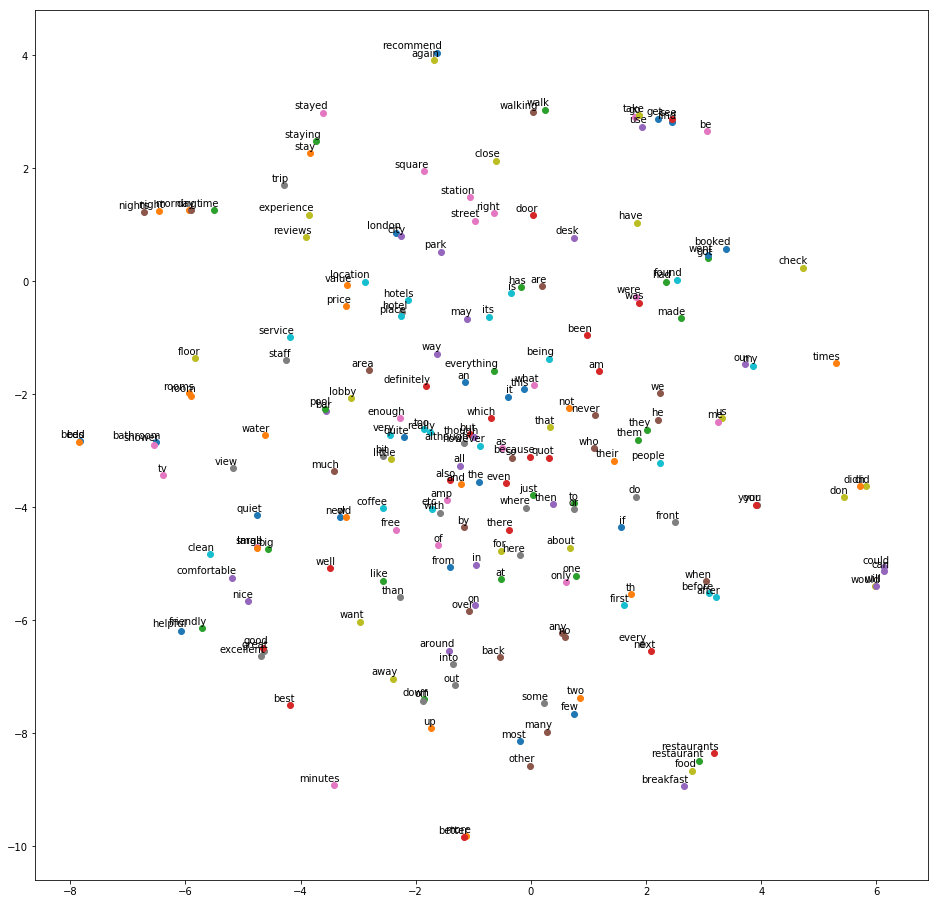

In [13]:
import matplotlib.pyplot as plt

def TSNE_visualization(X, words):
    X = np.array(X)
    print("Computed X: ", X.shape)
    X_embedded = TSNE(n_components=2, n_iter=2000, perplexity=40, verbose=2, random_state=23).fit_transform(X)
    print("Computed t-SNE", X_embedded.shape)
    plt.figure(figsize=(16, 16)) 
    for i in range(X_embedded.shape[0]):
        plt.scatter(X_embedded[i,0],X_embedded[i,1])
        plt.annotate(words[i],
                xy=(X_embedded[i,0],X_embedded[i,1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
    plt.show()
        
TSNE_visualization(X,vocab_samples)

## Word2Vec Implementation based on Pytorch
Let's implement and train word2vec model by ourselfs. We will build both SkipGram model and CBOW model. As illustrated in the figure, SkipGram model gets center word as input and output the context word (which can be any word in the context window); CBOW model gets all context words as input and output center word. We need to gather the training data as pairs of center word and context word.
![alt text](https://skymind.ai/images/wiki/word2vec_diagrams.png)

In [14]:
def gather_word_freqs(split_text, min_count=5):
    print('building vocabulary ...')
    tmp_vocab = {}
    ix_to_word = {}
    word_to_ix = {}
    total = 0.0
    for doc in split_text:
        for word in doc:
            if word not in tmp_vocab:
                tmp_vocab[word] = 0
            tmp_vocab[word] += 1.0
            total += 1.0
    vocab = {}
    for word, count in list(tmp_vocab.items()):
        if count >= min_count:
            vocab[word] = count
            ix_to_word[len(word_to_ix)] = word
            word_to_ix[word] = len(word_to_ix)
    new_split_text = []
    for doc in split_text:
        new_doc = []
        for i, word in enumerate(doc):
            if word in vocab:
                new_doc.append(word)
        new_split_text.append(new_doc)
    print('vocabulary size', len(vocab.keys()), len(word_to_ix), len(ix_to_word))
    return new_split_text, vocab, word_to_ix, ix_to_word

Exercise: collect training data. Input 'split_text' is a list of reviews, and each review is a list of words. Each word in each review can be a center word. Then we can get the context word according to the size of context window, and get training data pair for SkipGram model or CBOW model.

In [15]:
def gather_training_data(split_text, word_to_ix, context_size, model_type = "skipgram"):
    print('collect training data pair ...')
    training_data = []
    for doc in split_text:
        for i, word in enumerate(doc):
            # TODO: collect the pair context and center word as training data
            # For SkipGram, one training data point should be [center_word, context_word]
            # For CBOW, one training data point should be [context_word_list, center_word]
            
            
            
            
            
            
            
    print('size of training dataset', len(training_data))
    return training_data

Exercise: build the model according to the diagram above. Note for SkipGram, given one center word, we just need to output the log probability of all words in vocabulary as one single context word. 

In [16]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

''' Skip-gram bag-of-words model for word2vec.
Parameters:
    vocab_size: number of defined words in the vocab
    embedding_dim: desired embedded vector dimension
'''
class SkipGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, center):
        # TODO: fill in the forward pass for SkipGram 
        # Given a center word, predict the probability for each word in the vocabulary as its context
        # Return log probability
        
        
        
        

''' Continuous bag-of-words model for word2vec.
Parameters:
    vocab_size: number of defined words in the vocab
    embedding_dim: desired embedded vector dimension
    context_size: number of context words used
'''
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embedding_dim = embedding_dim
        self.context_size = context_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, contexts):
        # TODO: fill in the forward pass for CBOW
        # Given the contexts, predict the probability for each word in vocabulary to be the center word
        # Return the log probability
        
        
        
        
        

Exercise: implement the generic training function. 

In [17]:
def train(texts, model_type, context_size, embedding_dim, batch_size, num_epochs, lr, device):
    # create the vocabulary and training data pairs
    processed_text, vocab, word_to_ix, ix_to_word = gather_word_freqs(texts)
    training_data = gather_training_data(processed_text, word_to_ix, context_size, model_type = model_type)
    # build the model and optimizer
    if model_type=='skipgram':
        model = SkipGram(len(vocab), embedding_dim)
    if model_type=='cbow':
        model = CBOW(len(vocab), embedding_dim, context_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(device)
    print(model)
    model.to(device)
    # train the model
    print("Starting training")
    for epoch in range(num_epochs):
        for iteration in range(int(len(vocab)/batch_size)):
            # TODO: randomly select batch of data,
            # send the data to device
            # call model to predict the log likelihood
            # define loss as negative log likelihood
            # backpropagate the loss and update the model parameter
            
            
            
            
            
            
            
            
            
            
        print("Epoch %d Loss: %.5f" % (epoch, loss.data))
    return model, vocab, word_to_ix


We'd like to train CBOW model on a small subset of the reviews, and check the learnt embedding by TSNE visualization.

In [21]:
np.random.seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, vocab, word_to_ix = train(texts=documents[:1000], model_type='cbow', context_size=10, 
      embedding_dim=128, batch_size=256, num_epochs=2000, lr=0.005, device=device)

building vocabulary ...
vocabulary size 2432 2432 2432
collect training data pair ...
size of training dataset 148468
cuda
CBOW(
  (embeddings): Embedding(2432, 128)
  (linear): Linear(in_features=128, out_features=2432, bias=True)
)
Starting training
Epoch 0 Loss: 8.94372
Epoch 1 Loss: 8.90366
Epoch 2 Loss: 7.98625
Epoch 3 Loss: 7.44032
Epoch 4 Loss: 7.43801
Epoch 5 Loss: 6.84629
Epoch 6 Loss: 7.07988
Epoch 7 Loss: 6.95472
Epoch 8 Loss: 6.72782
Epoch 9 Loss: 6.82452
Epoch 10 Loss: 6.26626
Epoch 11 Loss: 6.81437
Epoch 12 Loss: 6.73369
Epoch 13 Loss: 6.58519
Epoch 14 Loss: 6.41142
Epoch 15 Loss: 6.31121
Epoch 16 Loss: 6.29557
Epoch 17 Loss: 6.59068
Epoch 18 Loss: 6.69071
Epoch 19 Loss: 6.18589
Epoch 20 Loss: 5.97734
Epoch 21 Loss: 6.19895
Epoch 22 Loss: 6.04351
Epoch 23 Loss: 6.64595
Epoch 24 Loss: 6.52357
Epoch 25 Loss: 6.33997
Epoch 26 Loss: 6.06106
Epoch 27 Loss: 6.17415
Epoch 28 Loss: 6.06926
Epoch 29 Loss: 5.86337
Epoch 30 Loss: 6.00113
Epoch 31 Loss: 6.03602
Epoch 32 Loss: 6.19495

Epoch 338 Loss: 4.04271
Epoch 339 Loss: 4.21530
Epoch 340 Loss: 4.09005
Epoch 341 Loss: 4.14596
Epoch 342 Loss: 4.16342
Epoch 343 Loss: 3.87032
Epoch 344 Loss: 4.02952
Epoch 345 Loss: 3.78175
Epoch 346 Loss: 3.84168
Epoch 347 Loss: 4.14315
Epoch 348 Loss: 3.79870
Epoch 349 Loss: 3.90292
Epoch 350 Loss: 4.25442
Epoch 351 Loss: 3.81614
Epoch 352 Loss: 3.81776
Epoch 353 Loss: 4.12456
Epoch 354 Loss: 3.96076
Epoch 355 Loss: 4.30966
Epoch 356 Loss: 4.02024
Epoch 357 Loss: 3.90678
Epoch 358 Loss: 3.97932
Epoch 359 Loss: 3.61891
Epoch 360 Loss: 4.26208
Epoch 361 Loss: 3.81030
Epoch 362 Loss: 4.20617
Epoch 363 Loss: 3.71207
Epoch 364 Loss: 4.06598
Epoch 365 Loss: 4.08149
Epoch 366 Loss: 3.89082
Epoch 367 Loss: 3.81019
Epoch 368 Loss: 4.05090
Epoch 369 Loss: 4.19615
Epoch 370 Loss: 3.97077
Epoch 371 Loss: 3.70593
Epoch 372 Loss: 3.98852
Epoch 373 Loss: 3.71392
Epoch 374 Loss: 3.78755
Epoch 375 Loss: 3.97603
Epoch 376 Loss: 3.78462
Epoch 377 Loss: 3.80832
Epoch 378 Loss: 3.94717
Epoch 379 Loss: 

Epoch 681 Loss: 3.07151
Epoch 682 Loss: 3.22745
Epoch 683 Loss: 2.92559
Epoch 684 Loss: 3.29538
Epoch 685 Loss: 2.91120
Epoch 686 Loss: 3.04541
Epoch 687 Loss: 3.41236
Epoch 688 Loss: 3.31912
Epoch 689 Loss: 3.31506
Epoch 690 Loss: 3.19461
Epoch 691 Loss: 3.31041
Epoch 692 Loss: 3.07954
Epoch 693 Loss: 3.20970
Epoch 694 Loss: 3.05546
Epoch 695 Loss: 3.40557
Epoch 696 Loss: 3.32479
Epoch 697 Loss: 3.27532
Epoch 698 Loss: 3.30324
Epoch 699 Loss: 3.35045
Epoch 700 Loss: 2.96149
Epoch 701 Loss: 3.33592
Epoch 702 Loss: 2.90041
Epoch 703 Loss: 3.16215
Epoch 704 Loss: 3.20230
Epoch 705 Loss: 3.37410
Epoch 706 Loss: 3.21631
Epoch 707 Loss: 3.27714
Epoch 708 Loss: 3.04694
Epoch 709 Loss: 3.33019
Epoch 710 Loss: 2.91894
Epoch 711 Loss: 3.01716
Epoch 712 Loss: 3.22431
Epoch 713 Loss: 3.08368
Epoch 714 Loss: 3.46113
Epoch 715 Loss: 3.29227
Epoch 716 Loss: 3.15769
Epoch 717 Loss: 2.99108
Epoch 718 Loss: 3.16720
Epoch 719 Loss: 3.23914
Epoch 720 Loss: 3.05022
Epoch 721 Loss: 3.22909
Epoch 722 Loss: 

Epoch 1024 Loss: 2.71146
Epoch 1025 Loss: 2.85165
Epoch 1026 Loss: 2.82507
Epoch 1027 Loss: 2.96378
Epoch 1028 Loss: 2.87051
Epoch 1029 Loss: 2.75143
Epoch 1030 Loss: 2.84686
Epoch 1031 Loss: 3.03169
Epoch 1032 Loss: 2.97724
Epoch 1033 Loss: 2.70133
Epoch 1034 Loss: 2.84113
Epoch 1035 Loss: 2.73136
Epoch 1036 Loss: 2.86016
Epoch 1037 Loss: 2.49352
Epoch 1038 Loss: 2.81640
Epoch 1039 Loss: 2.78947
Epoch 1040 Loss: 2.78025
Epoch 1041 Loss: 2.44207
Epoch 1042 Loss: 3.12811
Epoch 1043 Loss: 3.02803
Epoch 1044 Loss: 2.98188
Epoch 1045 Loss: 2.54905
Epoch 1046 Loss: 2.70780
Epoch 1047 Loss: 2.65745
Epoch 1048 Loss: 2.95689
Epoch 1049 Loss: 2.87120
Epoch 1050 Loss: 2.61310
Epoch 1051 Loss: 3.00524
Epoch 1052 Loss: 2.57368
Epoch 1053 Loss: 2.62222
Epoch 1054 Loss: 2.72611
Epoch 1055 Loss: 2.91033
Epoch 1056 Loss: 2.55464
Epoch 1057 Loss: 2.80084
Epoch 1058 Loss: 2.78832
Epoch 1059 Loss: 2.89997
Epoch 1060 Loss: 2.72679
Epoch 1061 Loss: 2.91795
Epoch 1062 Loss: 2.73317
Epoch 1063 Loss: 3.19509


Epoch 1357 Loss: 2.67848
Epoch 1358 Loss: 2.87456
Epoch 1359 Loss: 2.77219
Epoch 1360 Loss: 2.65369
Epoch 1361 Loss: 2.64190
Epoch 1362 Loss: 2.52941
Epoch 1363 Loss: 2.66388
Epoch 1364 Loss: 2.32036
Epoch 1365 Loss: 2.58651
Epoch 1366 Loss: 2.60054
Epoch 1367 Loss: 2.75311
Epoch 1368 Loss: 2.56371
Epoch 1369 Loss: 2.66457
Epoch 1370 Loss: 2.61424
Epoch 1371 Loss: 2.50361
Epoch 1372 Loss: 2.43229
Epoch 1373 Loss: 2.75342
Epoch 1374 Loss: 2.62029
Epoch 1375 Loss: 2.64743
Epoch 1376 Loss: 2.68927
Epoch 1377 Loss: 2.40103
Epoch 1378 Loss: 2.69486
Epoch 1379 Loss: 2.53807
Epoch 1380 Loss: 2.68266
Epoch 1381 Loss: 2.51207
Epoch 1382 Loss: 2.64609
Epoch 1383 Loss: 2.66038
Epoch 1384 Loss: 2.62968
Epoch 1385 Loss: 2.49370
Epoch 1386 Loss: 2.63697
Epoch 1387 Loss: 2.75402
Epoch 1388 Loss: 2.64678
Epoch 1389 Loss: 2.62356
Epoch 1390 Loss: 2.66373
Epoch 1391 Loss: 2.46170
Epoch 1392 Loss: 2.76239
Epoch 1393 Loss: 2.35983
Epoch 1394 Loss: 2.69800
Epoch 1395 Loss: 2.53407
Epoch 1396 Loss: 2.50314


Epoch 1687 Loss: 2.51805
Epoch 1688 Loss: 2.65383
Epoch 1689 Loss: 2.21605
Epoch 1690 Loss: 2.57939
Epoch 1691 Loss: 2.34868
Epoch 1692 Loss: 2.39457
Epoch 1693 Loss: 2.50549
Epoch 1694 Loss: 2.51223
Epoch 1695 Loss: 2.28624
Epoch 1696 Loss: 2.32243
Epoch 1697 Loss: 2.36705
Epoch 1698 Loss: 2.49200
Epoch 1699 Loss: 2.42118
Epoch 1700 Loss: 2.39453
Epoch 1701 Loss: 2.33656
Epoch 1702 Loss: 2.41663
Epoch 1703 Loss: 2.51577
Epoch 1704 Loss: 2.37481
Epoch 1705 Loss: 2.33877
Epoch 1706 Loss: 2.51675
Epoch 1707 Loss: 2.36742
Epoch 1708 Loss: 2.50421
Epoch 1709 Loss: 2.22952
Epoch 1710 Loss: 2.35629
Epoch 1711 Loss: 2.34819
Epoch 1712 Loss: 2.24557
Epoch 1713 Loss: 2.17057
Epoch 1714 Loss: 2.41995
Epoch 1715 Loss: 2.63667
Epoch 1716 Loss: 2.19833
Epoch 1717 Loss: 2.43840
Epoch 1718 Loss: 2.29899
Epoch 1719 Loss: 2.76029
Epoch 1720 Loss: 2.43199
Epoch 1721 Loss: 2.54563
Epoch 1722 Loss: 2.52263
Epoch 1723 Loss: 2.46630
Epoch 1724 Loss: 2.71615
Epoch 1725 Loss: 2.43229
Epoch 1726 Loss: 2.65113


In [22]:
def embed(model, word, word_to_idx, device):
    idx = word_to_ix[word]
    var = autograd.Variable(torch.LongTensor([idx]))
    var = var.to(device)
    embeds = model.embeddings(var)
    return embeds.cpu().detach().numpy()

Computed X:  (200, 128)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.759167
[t-SNE] Computed conditional probabilities in 0.026s
[t-SNE] Iteration 50: error = 111.3121567, gradient norm = 0.2585000 (50 iterations in 0.337s)
[t-SNE] Iteration 100: error = 120.5761719, gradient norm = 0.1998123 (50 iterations in 0.295s)
[t-SNE] Iteration 150: error = 112.6241913, gradient norm = 0.2624517 (50 iterations in 0.284s)
[t-SNE] Iteration 200: error = 112.6328506, gradient norm = 0.2076124 (50 iterations in 0.296s)
[t-SNE] Iteration 250: error = 117.7500458, gradient norm = 0.2286750 (50 iterations in 0.306s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 117.750046
[t-SNE] Iteration 300: error = 2.1544089, gradient norm = 0.0367107 (50 iterations in 0.299s)
[t-SNE] Iteration 350: error = 1.99547

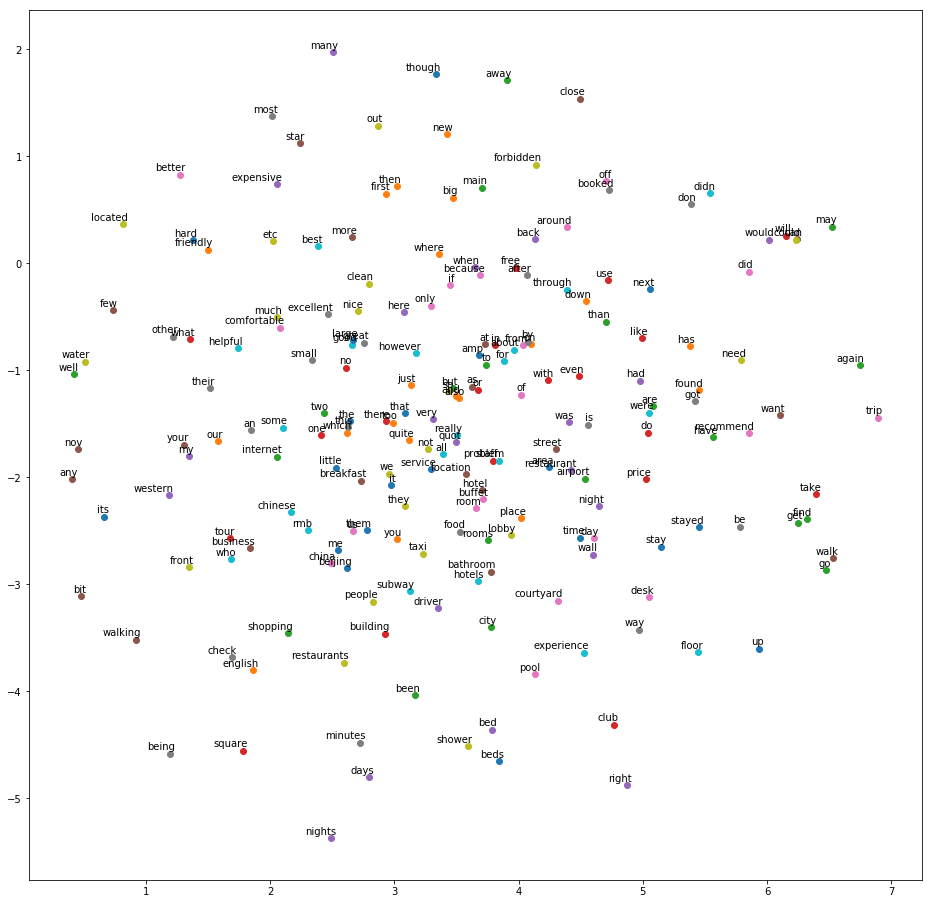

In [23]:

w2cSorted=dict(sorted(vocab.items(), key=lambda x: x[1],reverse=True))
vocab_samples = []
for item in w2cSorted.keys():
    vocab_samples.append(item)

vocab_samples = vocab_samples[:200]

X = []
for word in vocab_samples:
    X.append(embed(model, word, word_to_ix, device)[0])
 
TSNE_visualization(X, vocab_samples)